In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import img_to_array

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 이미지 증강 객체 생성
gen = ImageDataGenerator(rotation_range=15, shear_range=0.1,
                         width_shift_range=0.3, rescale=1./255)

# 증강 이미지 적용 및 실행
data_path = '/content/drive/MyDrive/flower_photos/'
batch_size = 2313
data_gen = gen.flow_from_directory(directory=data_path, batch_size=batch_size,
                                   shuffle=True, target_size=(100, 100),
                                   class_mode='categorical')

Found 2313 images belonging to 5 classes.


In [4]:
img, label = data_gen.next()
print(len(img))

2313


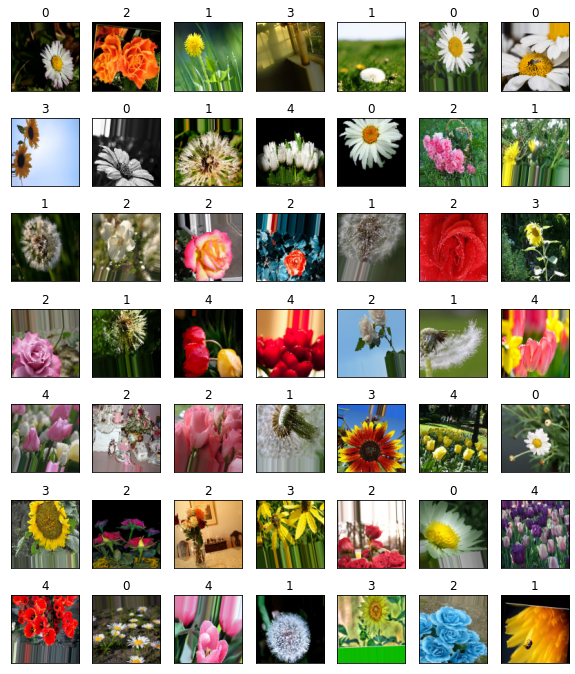

In [5]:
plt.figure(figsize=(10, 12))
for i in range(49):
    plt.subplot(7, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(label[i])))
    plt.imshow(img[i])

In [6]:
result = []
for i in range(2313):
    result.append(np.argmax(label[i]))
result = np.array(result).reshape(-1, 1)

print(result.shape)

(2313, 1)


In [7]:
# train_data, test_data split
x_train, x_test, y_train, y_test = train_test_split(
    img, result, test_size=0.3, shuffle=False, random_state=1004)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1619, 100, 100, 3)
(694, 100, 100, 3)
(1619, 1)
(694, 1)


In [8]:
# one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

print(y_train.shape)
print(y_test.shape)

(1619, 5)
(694, 5)


In [9]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',
               input_shape=(100, 100, 3)))
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(5, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                        

In [10]:
start_time = datetime.now()

cnn.compile(loss='categorical_crossentropy',
            optimizer=Adam(), metrics=['accuracy'])

# 손실함수를 10 epochs 마다 검사하여 더 이상 줄어들지 않으면 종료
# EarlyStopping(모니터링 값, 대기 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 학습 중인 모델을 자동 저장
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/data/bast.h5',
                                   monitor='val_loss',
                                   save_base_only=True,
                                   verbose=1)

hist = cnn.fit(x_train, y_train, batch_size=256, epochs=250,
               validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint])

end_time = datetime.now()

print('경과시간 =', end_time - start_time)

Epoch 1/250
7/7 [==============================] - ETA: 0s - loss: 1.6103 - accuracy: 0.2304
Epoch 1: saving model to /content/drive/MyDrive/data/bast.h5
7/7 [==============================] - 11s 720ms/step - loss: 1.6103 - accuracy: 0.2304 - val_loss: 1.5988 - val_accuracy: 0.2579
Epoch 2/250
7/7 [==============================] - ETA: 0s - loss: 1.5900 - accuracy: 0.2551
Epoch 2: saving model to /content/drive/MyDrive/data/bast.h5
7/7 [==============================] - 2s 276ms/step - loss: 1.5900 - accuracy: 0.2551 - val_loss: 1.5500 - val_accuracy: 0.2997
Epoch 3/250
7/7 [==============================] - ETA: 0s - loss: 1.5341 - accuracy: 0.3057
Epoch 3: saving model to /content/drive/MyDrive/data/bast.h5
7/7 [==============================] - 2s 280ms/step - loss: 1.5341 - accuracy: 0.3057 - val_loss: 1.5010 - val_accuracy: 0.3790
Epoch 4/250
7/7 [==============================] - ETA: 0s - loss: 1.3898 - accuracy: 0.4089
Epoch 4: saving model to /content/drive/MyDrive/data/bast

In [11]:
cnn.evaluate(x_test, y_test)

22/22 [==============================] - 1s 23ms/step - loss: 0.8050 - accuracy: 0.7565


[0.8050169348716736, 0.7564841508865356]

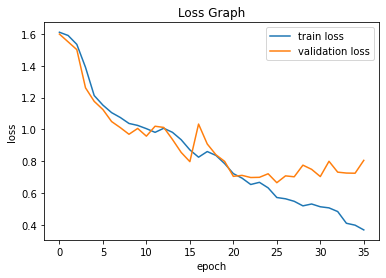

In [12]:
plt.title('Loss Graph')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')
plt.show()

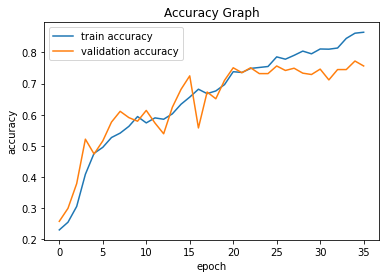

In [13]:
plt.title('Accuracy Graph')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

In [14]:
predictions = cnn.predict(x_test)
map = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

print(predictions.dtype)
print(y_test.dtype)

print(predictions[0])
print(y_test[0])

22/22 [==============================] - 0s 11ms/step
float32
float32
[9.9998426e-01 1.0584892e-05 4.2109655e-06 5.7502126e-07 3.3918911e-07]
[1. 0. 0. 0. 0.]


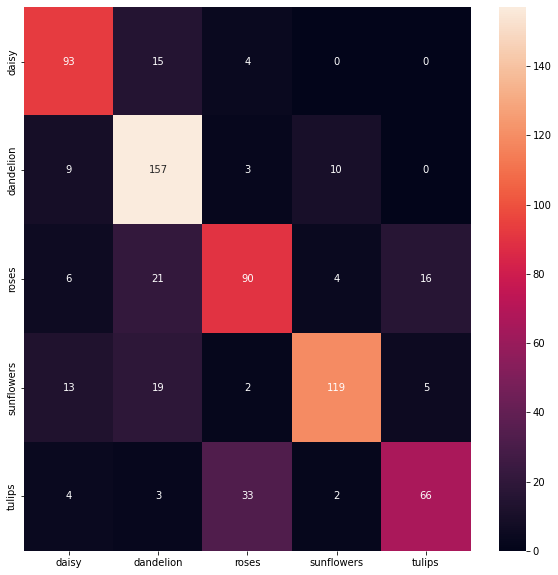

In [15]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=map, yticklabels=map)
plt.show()

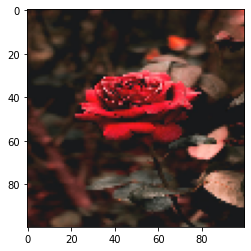

In [16]:
img_path = '/content/drive/MyDrive/flower/rose1.jpg'
img = load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

In [17]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(f"예측 결과는 {map[np.argmax(cnn.predict(img_batch))]} 입니다.")

1/1 [==============================] - 0s 112ms/step
예측 결과는 roses 입니다.


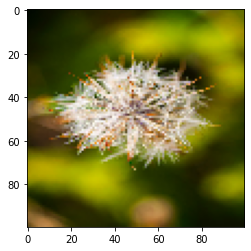

In [18]:
img_path = '/content/drive/MyDrive/flower/dandelion1.jpg'
img = load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

In [19]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(f"예측 결과는 {map[np.argmax(cnn.predict(img_batch))]} 입니다.")

1/1 [==============================] - 0s 19ms/step
예측 결과는 daisy 입니다.


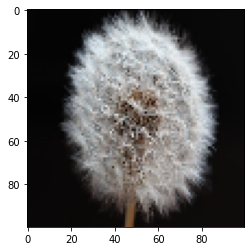

In [20]:
img_path = '/content/drive/MyDrive/flower/dandelion2.jpg'
img = load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

In [21]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(f"예측 결과는 {map[np.argmax(cnn.predict(img_batch))]} 입니다.")

1/1 [==============================] - 0s 18ms/step
예측 결과는 daisy 입니다.


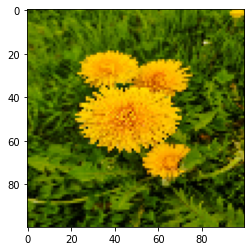

In [22]:
img_path = '/content/drive/MyDrive/flower/dandelion3.jpg'
img = load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

In [23]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(f"예측 결과는 {map[np.argmax(cnn.predict(img_batch))]} 입니다.")

1/1 [==============================] - 0s 16ms/step
예측 결과는 sunflowers 입니다.


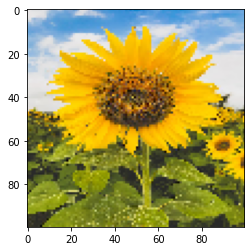

In [24]:
img_path = '/content/drive/MyDrive/flower/sunflower1.jpg'
img = load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

In [25]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(f"예측 결과는 {map[np.argmax(cnn.predict(img_batch))]} 입니다.")

1/1 [==============================] - 0s 16ms/step
예측 결과는 sunflowers 입니다.


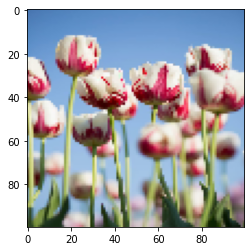

In [26]:
img_path = '/content/drive/MyDrive/flower/tulip1.jpg'
img = load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

In [27]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(f"예측 결과는 {map[np.argmax(cnn.predict(img_batch))]} 입니다.")

1/1 [==============================] - 0s 21ms/step
예측 결과는 sunflowers 입니다.


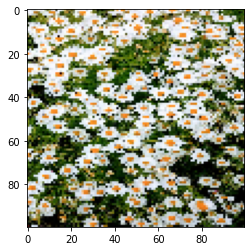

In [28]:
img_path = '/content/drive/MyDrive/flower/daisy1.jpg'
img = load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

In [29]:
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(f"예측 결과는 {map[np.argmax(cnn.predict(img_batch))]} 입니다.")

1/1 [==============================] - 0s 18ms/step
예측 결과는 daisy 입니다.


In [35]:
from tensorflow import keras

mod_path = '/content/drive/MyDrive/data/bast.h5'
keras_mod = keras.models.load_model(mod_path)
converter = tf.lite.TFLiteConverter.from_keras_model(keras_mod)
tflite_model = converter.convert()
with tf.io.gfile.GFile('converted_model_flower.tflite', 'wb') as f:
  f.write(tflite_model)